In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
import os
import pandas as pd

train_dir = '/content/drive/MyDrive/ISIC Original Data/Train'
test_dir = '/content/drive/MyDrive/ISIC Original Data/Test'

# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df
df

<ipython-input-2-34ebee65a41a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-2-34ebee65a41a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-2-34ebee65a41a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-2-34ebee65a41a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_pa

image_path label
0     /content/drive/MyDrive/ISIC Original Data/Trai...     0
1     /content/drive/MyDrive/ISIC Original Data/Trai...     0
2     /content/drive/MyDrive/ISIC Original Data/Trai...     0
3     /content/drive/MyDrive/ISIC Original Data/Trai...     0
4     /content/drive/MyDrive/ISIC Original Data/Trai...     0
...                                                 ...   ...
1759  /content/drive/MyDrive/ISIC Original Data/Test...     6
1760  /content/drive/MyDrive/ISIC Original Data/Test...     6
1761  /content/drive/MyDrive/ISIC Original Data/Test...     6
1762  /content/drive/MyDrive/ISIC Original Data/Test...     6
1763  /content/drive/MyDrive/ISIC Original Data/Test...     6

[1764 rows x 2 columns]

In [ ]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'melanoma',
 2: 'basal cell carcinoma',
 3: 'pigmented benign keratosis',
 4: 'squamous cell carcinoma',
 5: 'vascular lesion',
 6: 'nevus'}

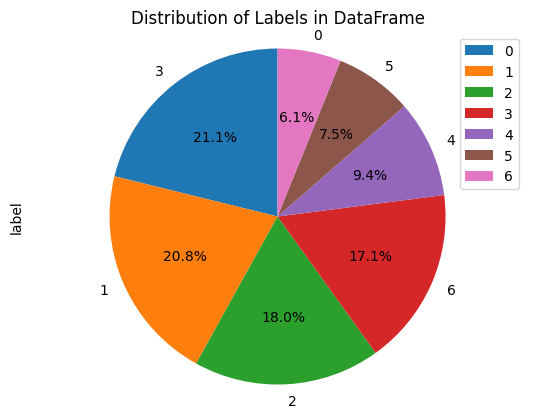

In [ ]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [ ]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              108       
1               melanoma                       367       
2               basal cell carcinoma           317       
3               pigmented benign keratosis     373       
4               squamous cell carcinoma        165       
5               vascular lesion                132       
6               nevus                          302       
------------------------------------------------------------
Total                                         1764      


In [ ]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

<ipython-input-6-bc8b811b80a6>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [ ]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

2

In [ ]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

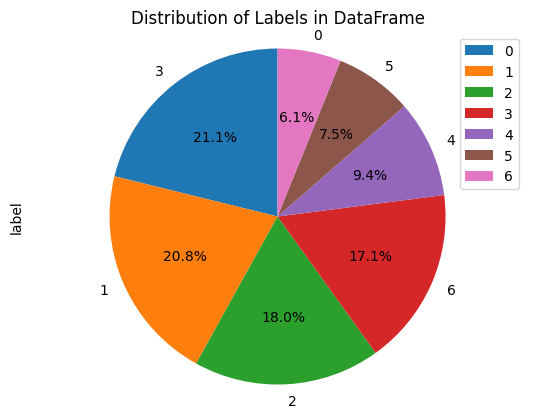

In [ ]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [ ]:
df.head()

image_path label  \
0  /content/drive/MyDrive/ISIC Original Data/Trai...     0   
1  /content/drive/MyDrive/ISIC Original Data/Trai...     0   
2  /content/drive/MyDrive/ISIC Original Data/Trai...     0   
3  /content/drive/MyDrive/ISIC Original Data/Trai...     0   
4  /content/drive/MyDrive/ISIC Original Data/Trai...     0   

                                               image  
0  [[[216, 173, 206], [215, 169, 202], [215, 167,...  
1  [[[133, 93, 95], [132, 92, 95], [137, 99, 105]...  
2  [[[215, 157, 181], [216, 160, 184], [218, 162,...  
3  [[[109, 76, 66], [114, 81, 75], [120, 87, 79],...  
4  [[[172, 137, 136], [175, 140, 139], [175, 136,...

In [ ]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              108       
1               melanoma                       367       
2               basal cell carcinoma           317       
3               pigmented benign keratosis     373       
4               squamous cell carcinoma        165       
5               vascular lesion                132       
6               nevus                          302       
------------------------------------------------------------
Total                                         1764      


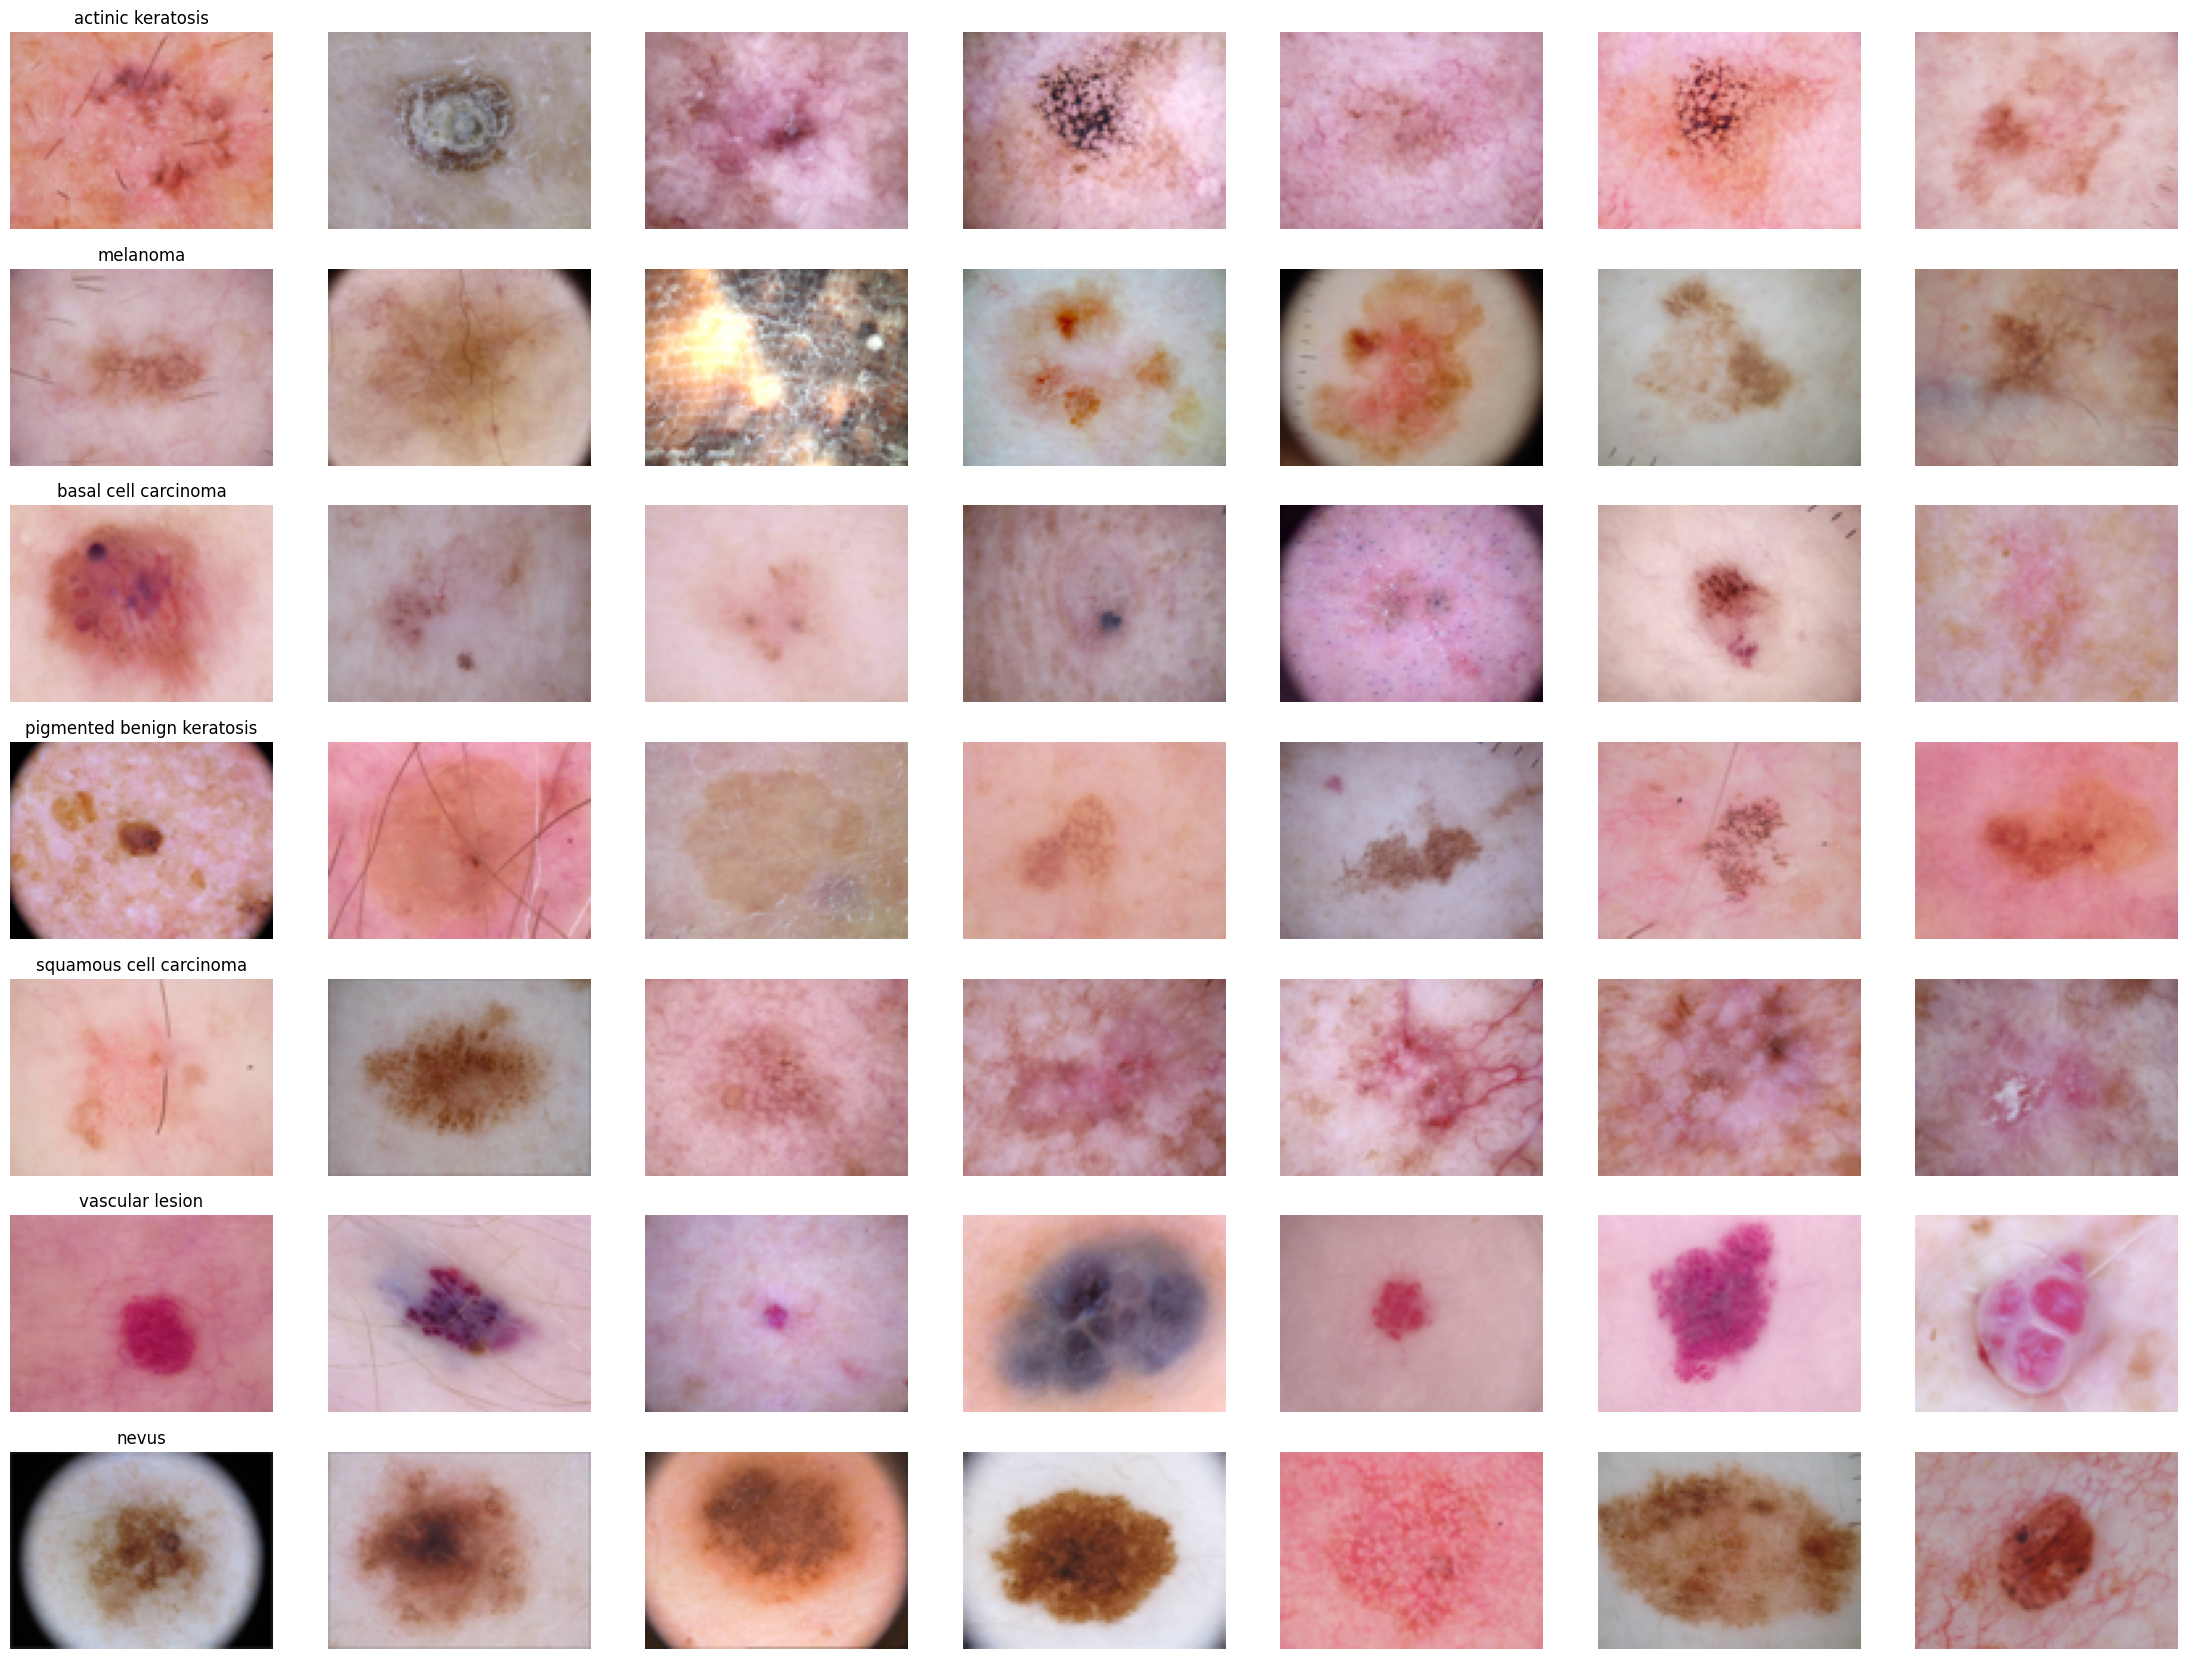

In [ ]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    1764
Name: image, dtype: int64

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
        # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
     # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

          # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)



     # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-18-63f691760f75>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-18-63f691760f75>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-18-63f691760f75>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-18-63f691760f75>:25: FutureWarn

In [ ]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2500      
1               melanoma                       2500      
2               basal cell carcinoma           2500      
3               pigmented benign keratosis     2500      
4               squamous cell carcinoma        2500      
5               vascular lesion                2500      
6               nevus                          2500      
------------------------------------------------------------
Total                                         17500     


In [ ]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [ ]:
features.head()

image
0  [[[159, 121, 115], [159, 120, 114], [158, 119,...
1  [[[176, 144, 150], [176, 144, 149], [173, 141,...
2  [[[111, 82, 74], [120, 88, 77], [128, 96, 81],...
3  [[[213, 179, 191], [212, 177, 188], [210, 176,...
4  [[[148, 113, 116], [148, 111, 114], [149, 117,...

In [ ]:
target.head()

0    0
1    3
2    1
3    4
4    1
Name: label, dtype: object

In [ ]:
print(target.shape,features.shape)

(17500,) (17500, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std


In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [ ]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")




Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               actinic keratosis              1604       413          483        2500      
1               melanoma                       1619       378          503        2500      
2               basal cell carcinoma           1599       405          496        2500      
3               pigmented benign keratosis     1576       404          520        2500      
4               squamous cell carcinoma        1593       397          510        2500      
5               vascular lesion                1635       381          484        2500      
6               nevus                          1574       422          504        2500      
----------------------------------------------------------

In [ ]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
4    2500
5    2500
6    2500
dtype: int64

In [ ]:
input_shape = df['image'][0].shape

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 24,224,327
Trainable params: 23,995,271
Non-trainable params: 229,056
_______________________________________

In [ ]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
# Fit the model
epochs = 50
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/50
350/350 [==============================] - ETA: 0s - loss: 1.2253 - accuracy: 0.5763

350/350 [==============================] - 79s 132ms/step - loss: 1.2253 - accuracy: 0.5763 - val_loss: 0.7732 - val_accuracy: 0.7314 - lr: 0.0010
Epoch 2/50
350/350 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.7913

350/350 [==============================] - 40s 115ms/step - loss: 0.6059 - accuracy: 0.7913 - val_loss: 0.5075 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 3/50
350/350 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8847

350/350 [==============================] - 41s 117ms/step - loss: 0.3215 - accuracy: 0.8847 - val_loss: 0.3778 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 4/50
350/350 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9204

350/350 [==============================] - 41s 116ms/step - loss: 0.2215 - accuracy: 0.9204 - val_loss: 0.2961 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 5/50
350/350 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9394

350/350 [==============================] - 43s 122ms/step - loss: 0.1677 - accuracy: 0.9394 - val_loss: 0.3392 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 6/50
350/350 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9488

350/350 [==============================] - 43s 123ms/step - loss: 0.1443 - accuracy: 0.9488 - val_loss: 0.2985 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 7/50
350/350 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9621

350/350 [==============================] - 41s 116ms/step - loss: 0.1038 - accuracy: 0.9621 - val_loss: 0.3200 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 8/50
350/350 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9676

350/350 [==============================] - 40s 116ms/step - loss: 0.0929 - accuracy: 0.9676 - val_loss: 0.2654 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 9/50
350/350 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9752

350/350 [==============================] - 43s 122ms/step - loss: 0.0709 - accuracy: 0.9752 - val_loss: 0.3365 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 10/50
350/350 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9722

350/350 [==============================] - 40s 115ms/step - loss: 0.0793 - accuracy: 0.9722 - val_loss: 0.2728 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 11/50
350/350 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9812

350/350 [==============================] - 40s 115ms/step - loss: 0.0567 - accuracy: 0.9812 - val_loss: 0.3298 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 12/50
350/350 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9831

350/350 [==============================] - 40s 115ms/step - loss: 0.0512 - accuracy: 0.9831 - val_loss: 0.3546 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 13/50
350/350 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9815

350/350 [==============================] - 40s 115ms/step - loss: 0.0531 - accuracy: 0.9815 - val_loss: 0.2976 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 14/50
350/350 [==============================] - ETA: 0s - loss: 0.0475 - accuracy: 0.9839

350/350 [==============================] - 40s 115ms/step - loss: 0.0475 - accuracy: 0.9839 - val_loss: 0.3056 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 15/50
350/350 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9854

350/350 [==============================] - 43s 122ms/step - loss: 0.0434 - accuracy: 0.9854 - val_loss: 0.3148 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 16/50
350/350 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9862

350/350 [==============================] - 43s 122ms/step - loss: 0.0398 - accuracy: 0.9862 - val_loss: 0.3394 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 17/50
350/350 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9870

350/350 [==============================] - 43s 122ms/step - loss: 0.0365 - accuracy: 0.9870 - val_loss: 0.2946 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 18/50
350/350 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9896

350/350 [==============================] - 43s 122ms/step - loss: 0.0289 - accuracy: 0.9896 - val_loss: 0.3165 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 19/50
350/350 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9875

350/350 [==============================] - 40s 115ms/step - loss: 0.0362 - accuracy: 0.9875 - val_loss: 0.3137 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 20/50
350/350 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9891

350/350 [==============================] - 40s 115ms/step - loss: 0.0293 - accuracy: 0.9891 - val_loss: 0.3082 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 21/50
350/350 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9876

350/350 [==============================] - 43s 122ms/step - loss: 0.0350 - accuracy: 0.9876 - val_loss: 0.2773 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 22/50
350/350 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9905

350/350 [==============================] - 40s 115ms/step - loss: 0.0277 - accuracy: 0.9905 - val_loss: 0.3076 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 23/50
350/350 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9906

350/350 [==============================] - 40s 115ms/step - loss: 0.0291 - accuracy: 0.9906 - val_loss: 0.2940 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 24/50
350/350 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9917

350/350 [==============================] - 43s 122ms/step - loss: 0.0232 - accuracy: 0.9917 - val_loss: 0.2989 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 25/50
350/350 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9928

350/350 [==============================] - 41s 116ms/step - loss: 0.0188 - accuracy: 0.9928 - val_loss: 0.2995 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 26/50
350/350 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9941

350/350 [==============================] - 40s 116ms/step - loss: 0.0137 - accuracy: 0.9941 - val_loss: 0.2760 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 27/50
350/350 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9955

350/350 [==============================] - 42s 121ms/step - loss: 0.0123 - accuracy: 0.9955 - val_loss: 0.2992 - val_accuracy: 0.9379 - lr: 0.0010
Epoch 28/50
350/350 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9953

350/350 [==============================] - 43s 122ms/step - loss: 0.0113 - accuracy: 0.9953 - val_loss: 0.3124 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 29/50
350/350 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9952

350/350 [==============================] - 48s 136ms/step - loss: 0.0110 - accuracy: 0.9952 - val_loss: 0.3256 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 30/50
350/350 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9948

350/350 [==============================] - 43s 122ms/step - loss: 0.0134 - accuracy: 0.9948 - val_loss: 0.2988 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 31/50
350/350 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9947

350/350 [==============================] - 41s 117ms/step - loss: 0.0150 - accuracy: 0.9947 - val_loss: 0.3366 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 32/50
350/350 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9941

350/350 [==============================] - 40s 115ms/step - loss: 0.0140 - accuracy: 0.9941 - val_loss: 0.3358 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 33/50
350/350 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9944

350/350 [==============================] - 42s 121ms/step - loss: 0.0125 - accuracy: 0.9944 - val_loss: 0.3361 - val_accuracy: 0.9339 - lr: 0.0010
Epoch 34/50
350/350 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9944

350/350 [==============================] - 40s 115ms/step - loss: 0.0134 - accuracy: 0.9944 - val_loss: 0.3422 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 35/50
350/350 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9952

350/350 [==============================] - 43s 122ms/step - loss: 0.0117 - accuracy: 0.9952 - val_loss: 0.3651 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 36/50
350/350 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9938

350/350 [==============================] - 43s 122ms/step - loss: 0.0149 - accuracy: 0.9938 - val_loss: 0.3397 - val_accuracy: 0.9289 - lr: 0.0010
Epoch 37/50
350/350 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9954

350/350 [==============================] - 43s 122ms/step - loss: 0.0108 - accuracy: 0.9954 - val_loss: 0.3354 - val_accuracy: 0.9411 - lr: 0.0010
Epoch 38/50
350/350 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9950

350/350 [==============================] - 43s 121ms/step - loss: 0.0113 - accuracy: 0.9950 - val_loss: 0.3601 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 39/50
350/350 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9945

350/350 [==============================] - 43s 122ms/step - loss: 0.0161 - accuracy: 0.9945 - val_loss: 0.3260 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 40/50
350/350 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9922

350/350 [==============================] - 40s 115ms/step - loss: 0.0199 - accuracy: 0.9922 - val_loss: 0.3354 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 41/50
350/350 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9931

350/350 [==============================] - 40s 115ms/step - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.3907 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 42/50
350/350 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9937

350/350 [==============================] - 43s 122ms/step - loss: 0.0181 - accuracy: 0.9937 - val_loss: 0.3416 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 43/50
350/350 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9964

350/350 [==============================] - 40s 115ms/step - loss: 0.0079 - accuracy: 0.9964 - val_loss: 0.3198 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 44/50
350/350 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9952

350/350 [==============================] - 40s 115ms/step - loss: 0.0100 - accuracy: 0.9952 - val_loss: 0.3263 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 45/50
350/350 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9961

350/350 [==============================] - 40s 115ms/step - loss: 0.0098 - accuracy: 0.9961 - val_loss: 0.3217 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 46/50
350/350 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9944

350/350 [==============================] - 40s 115ms/step - loss: 0.0147 - accuracy: 0.9944 - val_loss: 0.3142 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 47/50
350/350 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9955

350/350 [==============================] - 40s 115ms/step - loss: 0.0091 - accuracy: 0.9955 - val_loss: 0.3096 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 48/50
350/350 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9954

350/350 [==============================] - 43s 122ms/step - loss: 0.0109 - accuracy: 0.9954 - val_loss: 0.3202 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 49/50
350/350 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9960

350/350 [==============================] - 43s 122ms/step - loss: 0.0082 - accuracy: 0.9960 - val_loss: 0.3177 - val_accuracy: 0.9343 - lr: 0.0010
Epoch 50/50
350/350 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9962

350/350 [==============================] - 43s 121ms/step - loss: 0.0081 - accuracy: 0.9962 - val_loss: 0.3445 - val_accuracy: 0.9357 - lr: 0.0010


In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

350/350 [==============================] - 13s 36ms/step - loss: 0.0037 - accuracy: 0.9979
Train: accuracy = 0.997857  ;  loss = 0.003713


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

110/110 [==============================] - 9s 50ms/step - loss: 0.3933 - accuracy: 0.9306
Testing: accuracy = 0.930571  ;  loss = 0.393277


110/110 [==============================] - 7s 32ms/step


<Axes: >

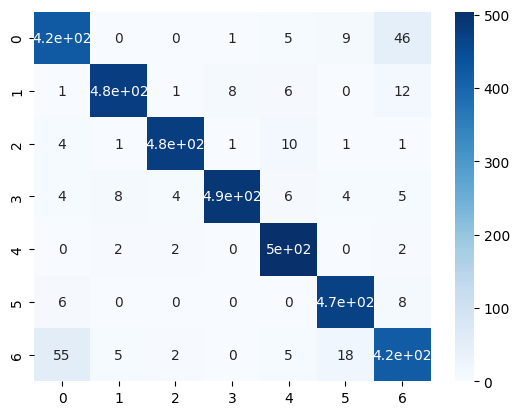

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9306
Precision: 0.9304
Recall: 0.9304
F1-score: 0.9302
Kappa score: 0.9190


In [ ]:
DenseNet Image Classification
The code provided is an implementation of a DenseNet-based image classification model using the Keras deep learning library. It performs the following steps:

Importing necessary libraries: The code begins by importing required libraries such as matplotlib, numpy, pandas, os, PIL, keras, tensorflow, scikit-learn, and others.

Data Preparation:

Defining directory paths: The paths to the training and test directories are defined using the variables train_dir and test_dir, respectively.

Creating dataframes: Two empty dataframes train_df and test_df are created to store the image paths and corresponding labels.

Populating dataframes: The code iterates over the directories in the training and test directories. For each image file, the image path and label are extracted and added to the respective dataframes.

Combining dataframes: The train and test dataframes are concatenated into a single dataframe called df using the pd.concat() function.

Exploratory Data Analysis:

Label distribution: A pie chart is plotted to visualize the distribution of labels in the df dataframe.

Class counts: The number of images in each class is counted and printed.

Class filtering: The code filters out classes with a number of images exceeding a predefined threshold (max_images_per_class).

Image Resizing and Augmentation:
Image resizing: The code uses PIL to resize the image arrays to a fixed size of 100x75 pixels.

Parallelization: The resizing process is parallelized using concurrent.futures.ThreadPoolExecutor to speed up the computation.

Augmentation: The code uses ImageDataGenerator from Keras to perform data augmentation, including rotation, shifting, shearing, zooming, and flipping. Augmented images are generated for each class until the desired number of images per class (max_images_per_class) is reached.

Data Splitting and Normalization:
Splitting data: The data is split into training, validation, and testing sets using train_test_split function from scikit-learn.
Normalization: The image arrays are normalized by subtracting the mean and dividing by the standard deviation separately for the training and testing sets.

Model Definition:
DenseNet201 architecture: The model architecture is defined using the Sequential API from Keras. The DenseNet201 pre-trained model is loaded with weights from the ImageNet dataset as the base model. The top layers of the base model are flattened and followed by a Dropout layer with a dropout rate of 0.5. Two dense layers are added, with ReLU activation in the first dense layer and softmax activation in the output layer.
Model Compilation and Training:

Compilation: The model is compiled with the SGD optimizer, a learning rate of 0.001, and categorical cross-entropy loss.
Learning rate reduction: A learning rate reduction callback is defined using ReduceLROnPlateau to adjust the learning rate during training based on the validation accuracy.
Model training: The model is trained using the fit() function, with the training and validation data, batch size, and number of epochs specified.
Model Evaluation:

Training and testing accuracy: The model is evaluated on the training and testing sets, and the accuracy and loss are printed.
Confusion matrix: The confusion matrix is calculated using confusion_matrix from scikit-learn and visualized using a heatmap with seaborn.
Additional metrics.

In [ ]:
from PIL import Image
import numpy as np
import keras

def preprocess_image(image_path):
    image = Image.open(image_path).resize((100, 75))
    image_array = np.array(image, dtype=np.float32) - 162.57063208888889
    image_array /= 41.96703347421026
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

def predict_image(image_path, model):
    # Preprocess the image
    image_array = preprocess_image(image_path)

    # Perform prediction
    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction)

    return predicted_class

model1 = keras.models.load_model("oranos-on-the-beat.h5")

image_path = '/content/drive/MyDrive/ISIC Original Data/Train/nevus/ISIC_0000023.jpg'

predicted_class = predict_image(image_path, model1)

print(f"Predicted class: {predicted_class}")


# 0               actinic keratosis
# 1               melanoma
# 2               basal cell carcinoma
# 3               pigmented benign keratosis
# 4               squamous cell carcinoma
# 5               vascular lesion
# 6               nevus


1/1 [==============================] - 3s 3s/step
Predicted class: 6


In [ ]:
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#---------------------------------------        Done         ------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------

In [ ]:
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#---------------------------------------        Done         ------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------

In [ ]:
# from PIL import Image
# image='/content/drive/MyDrive/ISIC Original Data/Train/actinic keratosis/ISIC_0025780.jpg'
# model1 = keras.models.load_model("skinDiseaseDetectionUsningCNN.h5")
# pre_img = (np.array(Image.open(image).resize((100, 75)), dtype= np.float32) -162.57063208888889)/ 41.96703347421026

In [ ]:
# pre_img.shape = (1,75, 100, 3)
# model1.predict(pre_img).argmax()

1/1 [==============================] - 4s 4s/step


0

In [ ]:
# print(x_test_mean, "   ", x_test_std)
# 162.57063208888889     41.96703347421026
# x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))

# from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
# from tensorflow.keras.applications import DenseNet201
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # DenseNet201
# model = Sequential()
# model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()